In [1]:
%load_ext autoreload
%autoreload 2

In [27]:
from Environment import Environment
from Agent import Agent
import numpy as np
from plot import plot
from Display import disp
from termcolor import colored

In [30]:
sigma = 1e-2
env = Environment(num_of_antennas=5, num_of_irs1=5, num_of_irs2=5,
                      path_loss_exponent=2, irs1_to_antenna=20,
                      irs2_to_antenna=30, irs1_to_irs2=40, transmitted_power=1)

U1 = env.CreateUser(distance_to_antenna=50, distance_to_irs1=50, distance_to_irs2=30,
                    noise_var=sigma**2, los_to_antenna=True, los_to_irs1=True,
                    los_to_irs2=True, sinr_threshold=3, penalty=0, allocated_power=1, weight=1)

U2 = env.CreateUser(distance_to_antenna=60, distance_to_irs1=40, distance_to_irs2=20,
                    noise_var=sigma**2, los_to_antenna=True, los_to_irs1=True,
                    los_to_irs2=True, sinr_threshold=3, penalty=0, allocated_power=1, weight=1)

In [ ]:
# Channels


Episode 1   Score ->  1.07      Avg-Score ->  1.07      + Max 😀 U1-SINR ->  1.39    U2-SINR ->  0.04    Sumrate ->  1.31   
Power split factor = 0.73 | Power noise = 0.17 
50
Episode 2   Score ->  1.00      Avg-Score ->  1.03      -        U1-SINR ->  0.78    U2-SINR ->  0.05    Sumrate ->  0.91   
Power split factor = 0.44 | Power noise = -0.098
100
Episode 3   Score ->  0.64      Avg-Score ->  0.90      -        U1-SINR ->  1.33    U2-SINR ->  0.49    Sumrate ->  1.79   
Power split factor = 0.6  | Power noise = 0.028
150
Episode 4   Score ->  0.31      Avg-Score ->  0.75      -        U1-SINR ->  10.72   U2-SINR ->  0.01    Sumrate ->  3.56   
Power split factor = 0.9  | Power noise = -0.1 
200
Episode 5   Score ->  0.01      Avg-Score ->  0.60      -        U1-SINR ->  10.96   U2-SINR ->  0.00    Sumrate ->  3.58   
Power split factor = 1.0  | Power noise = 0.0  
250


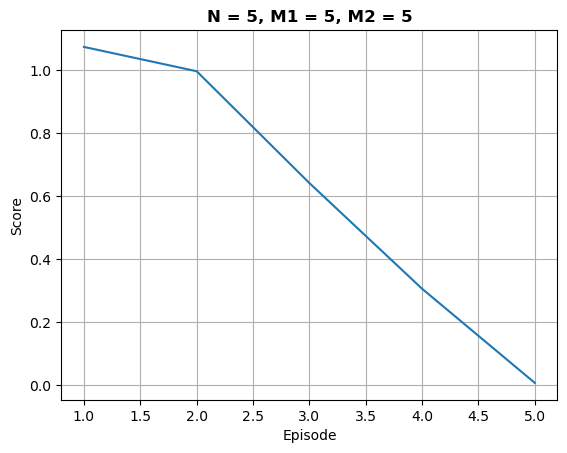

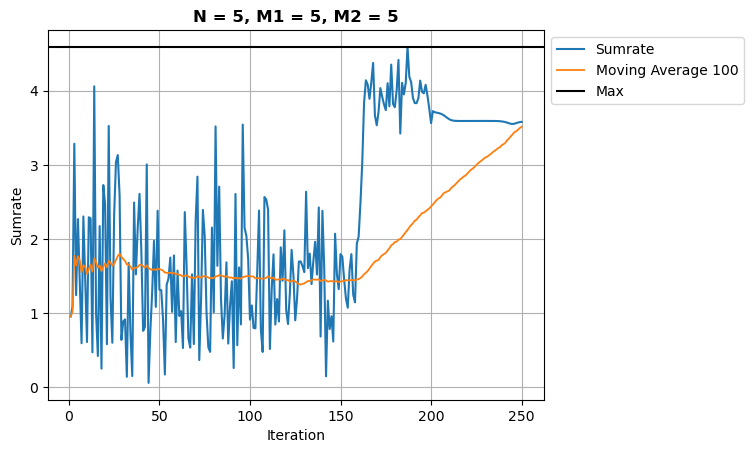

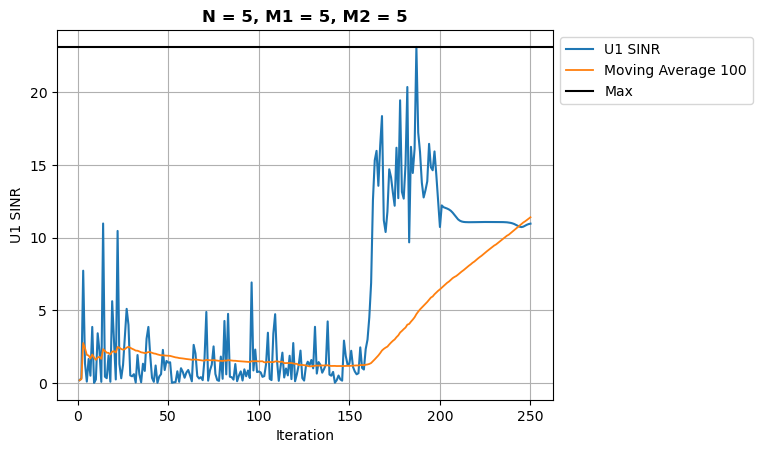

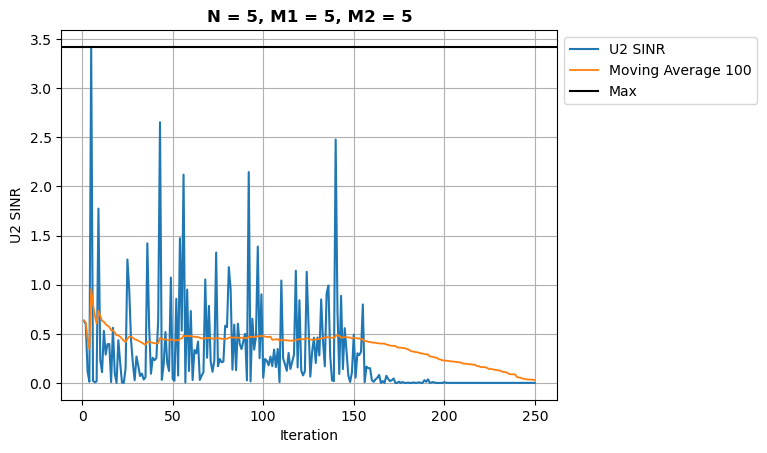





[4.60479921e-03 1.79999785e+02 1.80000000e+02 1.79995365e+02
 1.76433553e+02]
************************************************************************************
[1.92187442e-04 1.80000000e+02 1.79999721e+02 2.19876188e-05
 6.56144701e+00]
************************************************************************************
4.592404190315344


In [71]:
num_of_actions = env.M1 + env.M2 + len(env.Users) * env.N + env.num_of_users - 1

agent = Agent(num_states=env.num_of_users, bound=1, batch_size=128, max_size=10000,
                env=env, n_actions=num_of_actions,
                noise=0.02, alpha=0.0002, beta=0.0004, fc1=512, fc2=256)


num_of_episodes = 5
num_of_iterations = 50

score_history = np.zeros((num_of_episodes,))
rewards = np.zeros((num_of_episodes, num_of_iterations))
sumrate = np.zeros((num_of_episodes, num_of_iterations))
U1_SINR = np.zeros((num_of_episodes, num_of_iterations))
U2_SINR = np.zeros((num_of_episodes, num_of_iterations))

Old_Avg = 0
obs = env.State()
# agent.noise = 0

for ep in range(num_of_episodes):
    score = 0
    obs = env.State()

    if ep < num_of_episodes / 4:
        agent.noise = 0.40
    elif ep < num_of_episodes * 2 / 4:
        agent.noise = 0.20
    elif ep < num_of_episodes * 3 / 4:
        agent.noise = 0.1
    elif ep < num_of_episodes * 3 / 4 :
        agent.noise = 0.05
    else:
        agent.noise = 0

    for iter in range(num_of_iterations):
        action = agent.choose_action(obs)

        new_state, reward, sumrate[ep][iter], SINRs = env.Step(action)

        # if iter == 0 or iter == num_of_iterations - 1:
        #     print("****************************************************************")
        #     print("action: ", np.array(action))
        #     print("state: ", obs)
        #     print("New state: ", new_state)
        #     print("SINR: ", SINRs)
        #     print("****************************************************************")

        agent.remember(obs, action, reward, new_state)
        agent.learn()
        obs = new_state
        score += reward
        rewards[ep][iter] = reward

        U1_SINR[ep][iter] = SINRs[0]
        U2_SINR[ep][iter] = SINRs[1]

    # agent.learn()
    score = score / num_of_iterations
    score_history[ep] = score
    New_Avg = score_history[:ep + 1].mean()

    disp(episod=ep, score=score, score_history=score_history,
            New_Avg=New_Avg, Old_Avg=Old_Avg, SINRs=SINRs, sumrate=sumrate[ep][iter])
    
    ac = np.array(action)
    power_noise = np.array(agent.power_noise)
    print("Power split factor = "+ colored(f"{ac[-1 : ][0]: <5.2}", "blue") +
           "| Power noise = " + colored(f"{power_noise[-1]: <5.2}", "blue") )
    
    print(agent.memory.buffer_counter)

    # obs = env.Reset()
    Old_Avg = New_Avg

plot(score_history=score_history, sumrate=sumrate,
        u1_sinr=U1_SINR, u2_sinr=U2_SINR, mean=False,
        title=f"N = {env.N}, M1 = {env.M1}, M2 = {env.M2}")

# agent.save_models()

print("\n\n\n")
print(np.diag(np.angle(env.Psi1, deg=True)))
print("************************************************************************************")
print(np.diag(np.angle(env.Psi2, deg=True)))
# np.linalg.norm(env.Users[1].w)
# np.angle(env.Users[0].w, deg=True)
print("************************************************************************************")
print(max(sumrate.reshape(num_of_episodes*num_of_iterations,)))


In [52]:
print(np.diag(np.angle(env.Psi1, deg=True)))
print("************************************************************************************")
print(np.diag(np.angle(env.Psi2, deg=True)))
# np.linalg.norm(env.Users[1].w)
# np.angle(env.Users[0].w, deg=True)
print("************************************************************************************")
print(max(sumrate.reshape(num_of_episodes*num_of_iterations,)))

[  5.80351911 102.90995479 123.30667377  60.71778774  78.84238601]
************************************************************************************
[1.80000000e+02 1.80000000e+02 1.79999979e+02 1.78838679e+02
 6.44566103e-04]
************************************************************************************
6.4951752893006685


In [51]:
print(np.linalg.norm(U1.w)**2 + np.linalg.norm(U2.w)**2)
# tmp = np.array([1,1,1])
# print(np.linalg.norm(tmp)**2)
# tmp = tmp * 1
# print(np.linalg.norm(tmp)**2)

1.0


In [54]:
print(U1.w)
print("-------------------------")
print(U2.w)

[[-0.325339  +3.98425362e-17j]
 [-0.23980131+2.19865401e-01j]
 [-0.325339  +3.98425362e-17j]
 [ 0.18288432+2.69070231e-01j]
 [-0.325339  +3.98425362e-17j]]
-------------------------
[[-0.26313257+1.57847358e-01j]
 [ 0.30684611+2.06826945e-05j]
 [ 0.30684602+2.42313152e-04j]
 [-0.28449912+1.14955600e-01j]
 [-0.30684611+3.75778109e-17j]]


In [63]:
from math import e, pi
print(np.diag(np.angle(env.Psi1, deg=False)))
print("************************************************************************************")
print(np.diag(np.angle(env.Psi2, deg=False)))


[0.10129052 1.79611754 2.15210745 1.05972531 1.37605923]
************************************************************************************
[3.14159265e+00 3.14159265e+00 3.14159228e+00 3.12132377e+00
 1.12498007e-05]
